In [1]:
from datos_municipio import *
import pandas as pd
import seaborn as sns
from datos import *
import os
import requests
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import style
import json
from shapely.geometry import shape

In [2]:
spain = Pais("spain")
ciudad = spain.buscar_ciudad("Madrid")

In [3]:
def wifis_año(year,municipio):
    nombre_archivo = f"{municipio.pertenece_a}/original/csv/{municipio.id}_wifi.csv"
    try:
        archivo = pd.read_csv(nombre_archivo)
    except OSError:
        return -20
    filtrado = archivo.loc[((archivo["lasttime"] >= f"{year}-01-01") | (archivo["lasttime"] == archivo["lastupdt"])) & (archivo["firsttime"] < f"{year+1}-01-01")]
    return len(filtrado)

In [4]:
with open("Municipios_IGN.geojson", encoding='utf-8') as file:
    archivo_limite_muns = json.load(file)
OBJECTID = []
NAMEUNIT = []
CODIGOINE = []
for i in range(len(archivo_limite_muns["features"])):
    OBJECTID.append(archivo_limite_muns["features"][i]["properties"]["OBJECTID"])
    NAMEUNIT.append(archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"])
    CODIGOINE.append(archivo_limite_muns["features"][i]["properties"]["CODIGOINE"])
data_muns_geojson = pd.DataFrame({"OBJECTID":OBJECTID,"NAMEUNIT":NAMEUNIT,"CODIGOINE":CODIGOINE})
def pintar_wifis_muns(municipio):
    for i in range(len(archivo_limite_muns["features"])):
        if archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"].lower() == municipio.id.lower():
            break
    mun = archivo_limite_muns["features"][i]
    data_muns_geojson["color"] = 10
    mapa_mun = px.choropleth_mapbox(data_muns_geojson, geojson=mun, locations="OBJECTID", featureidkey="properties.OBJECTID",color="color",
    mapbox_style="carto-positron", zoom=11, center={"lat": mun["geometry"]["coordinates"][0][0][0][1], "lon": mun["geometry"]["coordinates"][0][0][0][0]},
    opacity=0.1, hover_name="NAMEUNIT")
    wifis_mun_csv = pd.read_csv(f"{municipio.pertenece_a}/original/csv/{municipio.id}_wifi.csv",low_memory=False)
    wifis_mun = px.scatter_mapbox(wifis_mun_csv, lat="trilat", lon="trilong", hover_name="ssid",
                                  color_discrete_sequence=["red"])
    mapa_mun.add_trace(wifis_mun.data[0])
    mapa_mun.show()
def pintar_mapa_mun(municipio):
    for i in range(len(archivo_limite_muns["features"])):
        if archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"].lower() == municipio.id.lower():
            break
    mun = archivo_limite_muns["features"][i]
    data_muns_geojson["color"] = 10
    mapa_mun = px.choropleth_mapbox(data_muns_geojson, geojson=mun, locations="OBJECTID", featureidkey="properties.OBJECTID",color="color",
    mapbox_style="carto-positron", zoom=11,center={"lat": mun["geometry"]["coordinates"][0][0][0][1], "lon": mun["geometry"]["coordinates"][0][0][0][0]},
    opacity=0.1, hover_name="NAMEUNIT")
    mapa_mun.show()

def pintar_mapa_operador(archivo_nombre,ciudad,operador):
    archivo = pd.read_csv(archivo_nombre)
    archivo = archivo[archivo["tipo"] == "OPERADOR"]
    muns = archivo["municipio"].unique().tolist()
    tabla = pd.crosstab(index=archivo["municipio"],columns=archivo["operador"]).apply(lambda r: r/r.sum()*100,axis=1)

    dict = {
    "type": "FeatureCollection",
    "name": "Municipios_IGN",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": []
    }
    OBJECTID = []
    NAMEUNIT = []
    CODIGOINE = []
    porcentaje_operador = []
    for j in ciudad.municipios:
        for m in range(len(archivo_limite_muns["features"])):
            if archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"].lower() == j.id.lower():
                dict["features"].append(archivo_limite_muns["features"][m])
                OBJECTID.append(archivo_limite_muns["features"][m]["properties"]["OBJECTID"])
                NAMEUNIT.append(archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"])
                CODIGOINE.append(archivo_limite_muns["features"][m]["properties"]["CODIGOINE"])
                break
    data=[]
    for i in range(len(NAMEUNIT)):
        if NAMEUNIT[i] in muns:
            index = muns.index(NAMEUNIT[i])
            porcentaje_operador.append(round(tabla[operador][index],2))
        else:
            porcentaje_operador.append(-20)
        mun = [OBJECTID[i],NAMEUNIT[i],CODIGOINE[i],porcentaje_operador[i]]
        data.append(mun)
    dataframe = pd.DataFrame(data,columns=["OBJECTID","NAMEUNIT","CODIGOINE","porcentaje_operador"])

    mapa_mun = px.choropleth(data_frame=dataframe, geojson=dict, locations="NAMEUNIT", featureidkey="properties.NAMEUNIT",color="porcentaje_operador",labels={"porcentaje_operador":f"% {operador}"})
    mapa_mun.update_geos(fitbounds="locations")
    mapa_mun.update_layout(title_text=f"PORCENTAJES DE {operador} EN LOS MUNICIPIOS ELEGIDOS")
    mapa_mun.show()

def pintar_densidad_wifis_habitante(ciudad):
    archivo = pd.read_excel("Poblacion-Madrid-2022.xlsx")
    dict = {
    "type": "FeatureCollection",
    "name": "Municipios_IGN",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": []
    }
    OBJECTID = []
    NAMEUNIT = []
    CODIGOINE = []
    porcentaje_operador = []
    for j in ciudad.municipios:
        for m in range(len(archivo_limite_muns["features"])):
            if archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"].lower() == j.id.lower():
                dict["features"].append(archivo_limite_muns["features"][m])
                OBJECTID.append(archivo_limite_muns["features"][m]["properties"]["OBJECTID"])
                NAMEUNIT.append(archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"])
                CODIGOINE.append(archivo_limite_muns["features"][m]["properties"]["CODIGOINE"])
                break
    data=[]
    for i in range(len(NAMEUNIT)):
        municipio = ciudad.buscar_municipio(NAMEUNIT[i])
        wifis = wifis_año(2021,municipio)
        if wifis > 0:
            for m in range(len(archivo)):
                if municipio.codigo_ine in archivo["Municipio"][m]:
                    porcentaje = round((wifis/archivo["2022"][m])*100,2)
                    porcentaje_operador.append(porcentaje)
        else:
            porcentaje_operador.append(-20)
        mun = [OBJECTID[i],NAMEUNIT[i],CODIGOINE[i],porcentaje_operador[i]]
        data.append(mun)
    dataframe = pd.DataFrame(data,columns=["OBJECTID","NAMEUNIT","CODIGOINE","porcentaje_operador"])

    mapa_mun = px.choropleth(data_frame=dataframe, geojson=dict, locations="NAMEUNIT", featureidkey="properties.NAMEUNIT",color="porcentaje_operador",labels={"porcentaje_operador":"% DENSIDAD"})
    mapa_mun.update_geos(fitbounds="locations")
    mapa_mun.update_layout(title_text=f"DENSIDAD DE WIFIS EN LOS MUNICIPIOS ANALIZADOS")
    mapa_mun.show()

def pintar_limite_mun_recursividad(municipio):
    OBJECTID = []
    NAMEUNIT = []
    CODIGOINE = []
    for i in range(len(archivo_limite_muns["features"])):
        if archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"].lower() == municipio.id.lower():
            OBJECTID.append(archivo_limite_muns["features"][i]["properties"]["OBJECTID"])
            NAMEUNIT.append(archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"])
            CODIGOINE.append(archivo_limite_muns["features"][i]["properties"]["CODIGOINE"])
            break
    mun = archivo_limite_muns["features"][i]
    municipio.poligono = poligono_municipio(municipio.id)
    municipio.limite = coordenadas_limite_municipio(municipio.poligono)
    municipio.poligono = poligono_municipio(municipio.id)
    municipio.limite = coordenadas_limite_municipio(municipio.poligono)
    lista = []
    for i in range(2):
        if i == 0:
            lista.append([municipio.limite[2],municipio.limite[i]])
            lista.append([municipio.limite[3],municipio.limite[i]])
        if i == 1:
            lista.append([municipio.limite[3],municipio.limite[i]])
            lista.append([municipio.limite[2],municipio.limite[i]])
    dif_x = (lista[0][0] - lista[1][0])/2
    dif_y = (lista[2][1] - lista[1][1])/2
    punto_medio_bajo = [lista[1][0]+dif_x,lista[0][1]]
    punto_medio_medio = [lista[1][0]+dif_x,lista[0][1]+dif_y]
    punto_izq_medio = [lista[0][0],lista[0][1]+dif_y]
    lista_1 = [lista[0],punto_medio_bajo,punto_medio_medio,punto_izq_medio]
    punto_der_medio = [lista[1][0],lista[0][1]+dif_y]
    lista_2 = [lista[1],punto_medio_bajo,punto_medio_medio,punto_der_medio]
    punto_medio_alto = [lista[1][0]+dif_x,lista[2][1]]
    lista_3 = [lista[2],punto_medio_alto,punto_medio_medio,punto_der_medio]
    lista_4 = [lista[3],punto_medio_alto,punto_medio_medio,punto_izq_medio]
    geojson = {
    "type": "FeatureCollection",
    "name": "Municipios_IGN",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": []
    }
    limite = { "type": "Feature", "properties": { "OBJECTID": 100000, "INSPIREID": "ES.IGN.SIGLIM34081616266", "NATCODE": "34081616266", "NAMEUNIT": "limite", "CODNUT1": "ES4", "CODNUT2": "ES42", "CODNUT3": "ES423", "CODIGOINE": "100000", "SHAPE_Length": 0, "SHAPE_Area": 0 }, "geometry": { "type": "MultiPolygon", "coordinates": [[lista_1],[lista_2],[lista_3],[lista_4]] }}
    geojson["features"].append(mun)
    geojson["features"].append(limite)
    OBJECTID.append(geojson["features"][1]["properties"]["OBJECTID"])
    NAMEUNIT.append(geojson["features"][1]["properties"]["NAMEUNIT"])
    CODIGOINE.append(geojson["features"][1]["properties"]["CODIGOINE"])
    data = pd.DataFrame({"OBJECTID":OBJECTID,"NAMEUNIT":NAMEUNIT,"CODIGOINE":CODIGOINE})
    mapa_mun = px.choropleth_mapbox(data,geojson=geojson,mapbox_style="carto-positron",locations="NAMEUNIT", featureidkey="properties.NAMEUNIT", zoom=10,center={"lat": mun["geometry"]["coordinates"][0][0][0][1], "lon": mun["geometry"]["coordinates"][0][0][0][0]},
    opacity=0.1)
    mapa_mun.show()

def pintar_limite_mun(municipio):
    OBJECTID = []
    NAMEUNIT = []
    CODIGOINE = []
    for i in range(len(archivo_limite_muns["features"])):
        if archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"].lower() == municipio.id.lower():
            OBJECTID.append(archivo_limite_muns["features"][i]["properties"]["OBJECTID"])
            NAMEUNIT.append(archivo_limite_muns["features"][i]["properties"]["NAMEUNIT"])
            CODIGOINE.append(archivo_limite_muns["features"][i]["properties"]["CODIGOINE"])
            break
    mun = archivo_limite_muns["features"][i]
    municipio.poligono = poligono_municipio(municipio.id)
    municipio.limite = coordenadas_limite_municipio(municipio.poligono)
    municipio.poligono = poligono_municipio(municipio.id)
    municipio.limite = coordenadas_limite_municipio(municipio.poligono)
    lista = []
    for i in range(2):
        if i == 0:
            lista.append([municipio.limite[2],municipio.limite[i]])
            lista.append([municipio.limite[3],municipio.limite[i]])
        if i == 1:
            lista.append([municipio.limite[3],municipio.limite[i]])
            lista.append([municipio.limite[2],municipio.limite[i]])
    geojson = {
    "type": "FeatureCollection",
    "name": "Municipios_IGN",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": []
    }
    limite = { "type": "Feature", "properties": { "OBJECTID": 100000, "INSPIREID": "ES.IGN.SIGLIM34081616266", "NATCODE": "34081616266", "NAMEUNIT": "limite", "CODNUT1": "ES4", "CODNUT2": "ES42", "CODNUT3": "ES423", "CODIGOINE": "100000", "SHAPE_Length": 0, "SHAPE_Area": 0 }, "geometry": { "type": "MultiPolygon", "coordinates": [[lista]] }}
    geojson["features"].append(mun)
    geojson["features"].append(limite)
    OBJECTID.append(geojson["features"][1]["properties"]["OBJECTID"])
    NAMEUNIT.append(geojson["features"][1]["properties"]["NAMEUNIT"])
    CODIGOINE.append(geojson["features"][1]["properties"]["CODIGOINE"])
    data = pd.DataFrame({"OBJECTID":OBJECTID,"NAMEUNIT":NAMEUNIT,"CODIGOINE":CODIGOINE})
    mapa_mun = px.choropleth_mapbox(data,geojson=geojson,mapbox_style="carto-positron",locations="NAMEUNIT", featureidkey="properties.NAMEUNIT", zoom=10,center={"lat": mun["geometry"]["coordinates"][0][0][0][1], "lon": mun["geometry"]["coordinates"][0][0][0][0]},
    opacity=0.1)
    mapa_mun.show()

def pintar_muns(ciudad):
    dict = {
    "type": "FeatureCollection",
    "name": "Municipios_IGN",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": []
    }
    OBJECTID = []
    NAMEUNIT = []
    CODIGOINE = []
    porcentaje_operador = []
    for j in ciudad.municipios:
        for m in range(len(archivo_limite_muns["features"])):
            if archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"].lower() == j.id.lower():
                dict["features"].append(archivo_limite_muns["features"][m])
                OBJECTID.append(archivo_limite_muns["features"][m]["properties"]["OBJECTID"])
                NAMEUNIT.append(archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"])
                CODIGOINE.append(archivo_limite_muns["features"][m]["properties"]["CODIGOINE"])
                break
    data=[]
    for i in range(len(NAMEUNIT)):
        municipio = ciudad.buscar_municipio(NAMEUNIT[i])
        existe = True
        try:
            pd.read_csv(f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_wifi.csv")
        except OSError:
            existe = False

        if existe:
            valor = "SI"
            porcentaje_operador.append(valor)
        else:
            porcentaje_operador.append("NO")
        mun = [OBJECTID[i],NAMEUNIT[i],CODIGOINE[i],porcentaje_operador[i]]
        data.append(mun)
    dataframe = pd.DataFrame(data,columns=["OBJECTID","NAMEUNIT","CODIGOINE","porcentaje_operador"])

    mapa_mun = px.choropleth(data_frame=dataframe, geojson=dict, locations="NAMEUNIT", featureidkey="properties.NAMEUNIT",color="porcentaje_operador",color_discrete_map={"SI":"darkblue","NO":"gray"},labels={"porcentaje_operador":"ELEGIDOS"})
    mapa_mun.update_geos(fitbounds="locations")
    mapa_mun.update_layout(title_text="MUNICIPIOS ANALIZADOS")
    mapa_mun.show()

def seleccionar_muns(ciudad,archivo_nombre):
    dict = {
    "type": "FeatureCollection",
    "name": "Municipios_IGN",
    "crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
    "features": []
    }
    OBJECTID = []
    NAMEUNIT = []
    CODIGOINE = []
    porcentaje_operador = []
    for j in ciudad.municipios:
        for m in range(len(archivo_limite_muns["features"])):
            if archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"].lower() == j.id.lower():
                dict["features"].append(archivo_limite_muns["features"][m])
                OBJECTID.append(archivo_limite_muns["features"][m]["properties"]["OBJECTID"])
                NAMEUNIT.append(archivo_limite_muns["features"][m]["properties"]["NAMEUNIT"])
                CODIGOINE.append(archivo_limite_muns["features"][m]["properties"]["CODIGOINE"])
                break
    data=[]
    archivo = pd.read_csv(archivo_nombre)
    lista_muns = archivo["municipio"].unique().tolist()
    for i in range(len(NAMEUNIT)):
        municipio = ciudad.buscar_municipio(NAMEUNIT[i])
        if municipio.id in lista_muns:
            valor = "SI"
            porcentaje_operador.append(valor)
        else:
            porcentaje_operador.append("NO")
        mun = [OBJECTID[i],NAMEUNIT[i],CODIGOINE[i],porcentaje_operador[i]]
        data.append(mun)
    dataframe = pd.DataFrame(data,columns=["OBJECTID","NAMEUNIT","CODIGOINE","porcentaje_operador"])

    mapa_mun = px.choropleth(data_frame=dataframe, geojson=dict, locations="NAMEUNIT", featureidkey="properties.NAMEUNIT",color="porcentaje_operador",color_discrete_map={"SI":"darkblue","NO":"gray"},labels={"porcentaje_operador":"ELEGIDOS"})
    mapa_mun.update_geos(fitbounds="locations")
    mapa_mun.update_layout(title_text="MUNICIPIOS SELECCIONADOS")
    mapa_mun.show()

In [ ]:
seleccionar_muns(ciudad,"Madrid/clasificador/Madrid_clasificador_elegidos_todo_agrupando1-2000_4-2019.csv")

In [ ]:
seleccionar_muns(ciudad,"Madrid/clasificador/Madrid_clasificador_elegidos_todo_agrupando6-2019_1-2023.csv")

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from dateutil import parser
def crecimiento_wifis_mun(municipio,columna="firsttime"):
    columna_to_datetime(municipio)
    nombre_archivo = f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_wifi.csv"
    archivo = pd.read_csv(nombre_archivo)
    lista_años = []
    lista_datos = []
    for i in range(2001,2024):
        lista_años.append(i)
        filtrado = archivo.loc[(archivo[columna] >= f"{i}-01-01") & (archivo[columna] < f"{i+1}-01-01")]
        lista_datos.append(len(filtrado))
    fig,ax = plt.subplots()
    ax.bar(lista_años,lista_datos)
    plt.title(f"{municipio.id} {columna}")
    plt.show()

def columna_to_datetime(municipio):
    nombre_archivo = f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_wifi.csv"
    archivo = pd.read_csv(nombre_archivo)
    modificado = False
    for i in range(len(archivo)):
        if isinstance(archivo.firsttime[i],str) and ("T" and "Z" in archivo.firsttime[i]):
            archivo.firsttime[i] = parser.parse(archivo.firsttime[i][:-2])
            modificado = True
        if isinstance(archivo.lasttime[i],str) and ("T" and "Z" in archivo.lasttime[i]):
            archivo.lasttime[i] = parser.parse(archivo.lasttime[i][:-2])
            modificado = True
        if isinstance(archivo.lastupdt[i],str) and ("T" and "Z" in archivo.lastupdt[i]):
            archivo.lastupdt[i] = parser.parse(archivo.lastupdt[i][:-2])
            modificado = True
    if modificado:
        archivo.to_csv(nombre_archivo,index=False)

def wifis_actuales(municipio):
    limite = 365
    columna_to_datetime(municipio)
    nombre_archivo = f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_wifi.csv"
    archivo = pd.read_csv(nombre_archivo)
    num_wifis_act = 0
    lista_diff = []
    for i in range(len(archivo)):
        lastupdt = datetime.strptime(archivo.lastupdt[i][:10],"%Y-%m-%d")
        lasttime = datetime.strptime(archivo.lasttime[i][:10],"%Y-%m-%d")
        diferencia = lastupdt - lasttime
        lista_diff.append(diferencia.days)
#        if archivo.lasttime[i][:10] == archivo.lastupdt[i][:10]:
        if diferencia.days <= limite:
            num_wifis_act += 1
    archivo = pd.DataFrame(lista_diff,columns=["Diferencia"])
    #archivo.to_csv(f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_diferencia_actual.csv",index=False)
    return num_wifis_act

def dif_dias_wifis(municipio):
    columna_to_datetime(municipio)
    nombre_archivo = f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_wifi.csv"
    archivo = pd.read_csv(nombre_archivo)
    num_wifis_act = 0
    lista_diff = []
    for i in range(len(archivo)):
        lastupdt = datetime.strptime(archivo.lastupdt[i][:10],"%Y-%m-%d")
        lasttime = datetime.strptime(archivo.lasttime[i][:10],"%Y-%m-%d")
        diferencia = lastupdt - lasttime
        lista_diff.append(diferencia.days)
        num_wifis_act += 1
    archivo = pd.DataFrame(lista_diff,columns=['Diferencia'])
    archivo.to_csv(f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_diferencia.csv",index=False)
    return archivo

def wifis_rango(municipio,inicio=2001,fin=2023):
    columna_to_datetime(municipio)
    nombre_archivo = f"{municipio.pertenece_a}/sanitizada/csv/{municipio.id}_wifi.csv"
    archivo = pd.read_csv(nombre_archivo)
    filtrado = archivo.loc[((archivo["lasttime"] >= f"{fin+1}-01-01") | (archivo["lasttime"] == archivo["lastupdt"])) & (archivo["firsttime"] < f"{fin+1}-01-01") & (archivo["firsttime"] >= f"{inicio}-01-01")]
    return filtrado

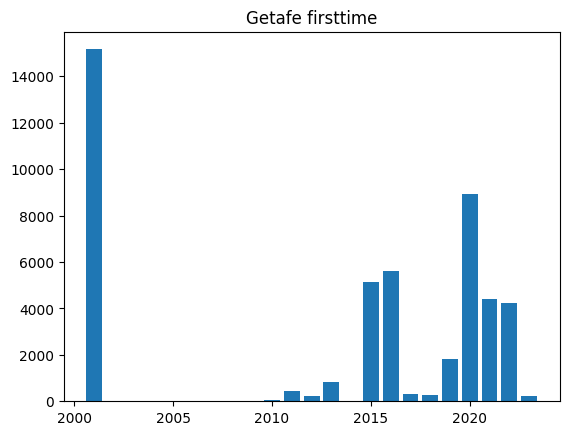

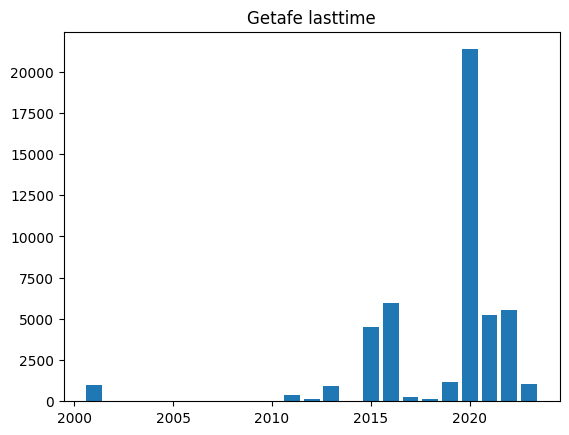

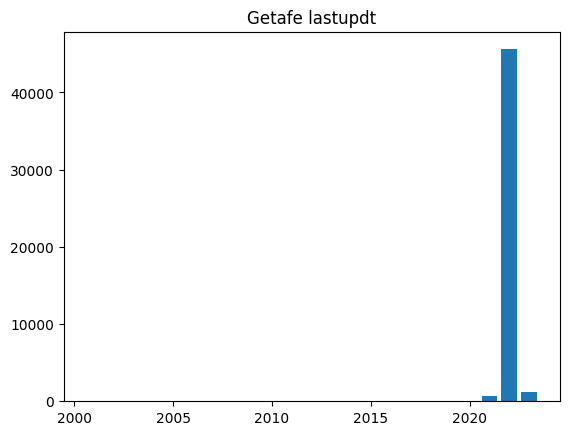

In [4]:
municipio = ciudad.buscar_municipio("Getafe")
crecimiento_wifis_mun(municipio)
crecimiento_wifis_mun(municipio,columna="lasttime")
crecimiento_wifis_mun(municipio,columna="lastupdt")

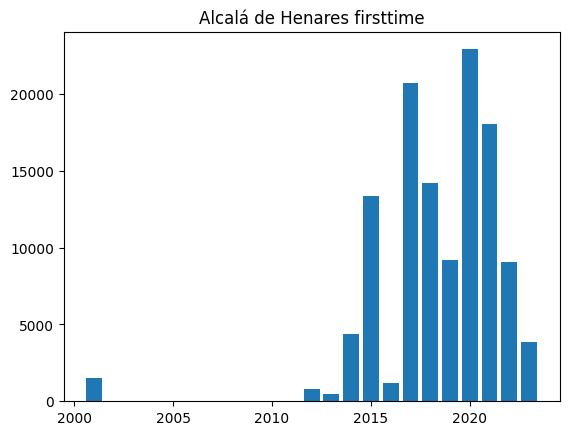

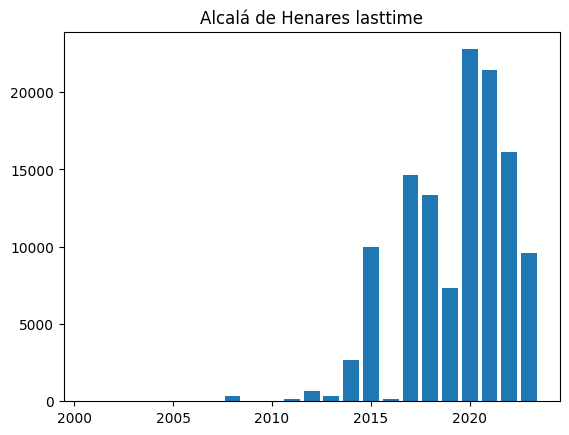

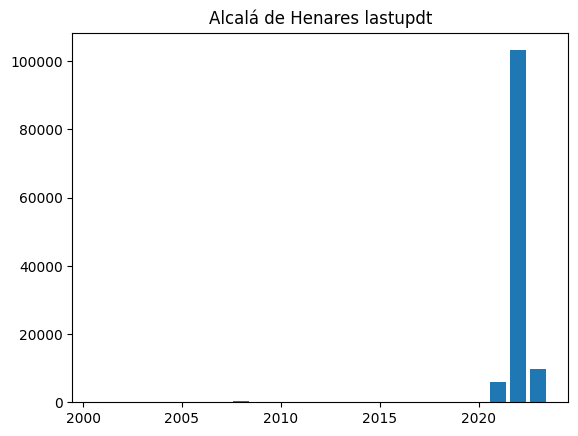

In [5]:
municipio = ciudad.buscar_municipio("Alcalá de Henares")
crecimiento_wifis_mun(municipio)
crecimiento_wifis_mun(municipio,columna="lasttime")
crecimiento_wifis_mun(municipio,columna="lastupdt")

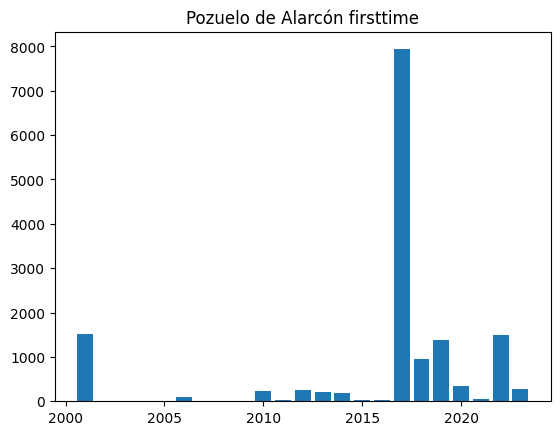

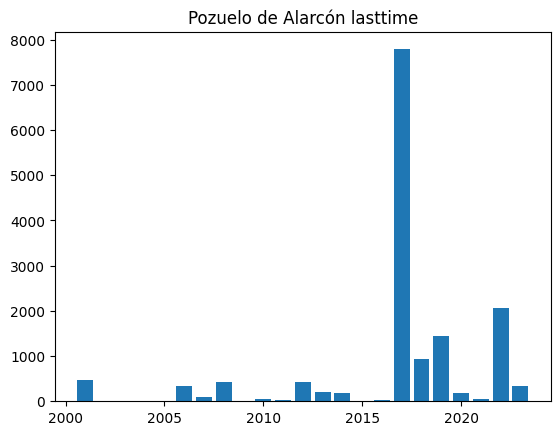

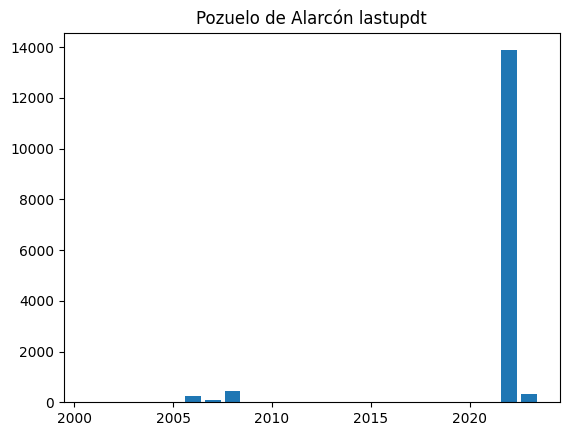

In [6]:
municipio = ciudad.buscar_municipio("Pozuelo de Alarcón")
crecimiento_wifis_mun(municipio)
crecimiento_wifis_mun(municipio,columna="lasttime")
crecimiento_wifis_mun(municipio,columna="lastupdt")